In [1]:
import biosppy.signals.resp as resp
import numpy as np
import csv as csv
import json    
import matplotlib.pyplot as plt


def calc_resp_intervals(data, last_breath = False):
    processed_data = resp.resp(signal=data, sampling_rate=200, show=False)
    filtered_signal = processed_data[1]
    inst_resp_rate = processed_data[4]
    
    signal_diff = np.diff(filtered_signal)
    signal_signum = signal_diff > 0
    
    resp_changes = np.append(np.where(signal_signum[:-1] != signal_signum[1:])[0], [len(signal_signum) - 1])
    
    if not last_breath:
        resp_intervals = np.append([0], resp_changes)
    
        interval_lengths = np.diff(resp_intervals)
    
        interval_breathe_in = [signal_signum[i] for i in resp_changes]
        
        return interval_lengths, interval_breathe_in
    
    else:
        last_interval = resp_changes[-1] - resp_changes[-2]
        
        return last_interval, signal_signum[resp_changes[-1]]
        

In [6]:
# resp_intervals: length of inhalation/exhalation in samples
# is_inhalation: True -> inhale, False: exhale
def resp_features(resp_intervals, is_inhalation, samplingRate):
    
    # calculate the average breath length in s
    breath_lengths = []
    i = 0

    while i < len(resp_intervals) - 1:
        if not is_inhalation[i]:
            i = i + 1
        else:
            breath_lengths.append(resp_intervals[i] + resp_intervals[i + 1])
            i = i + 2
    
    avg_breath = np.average(breath_lengths) / samplingRate
    
    # calculate the inhalation/exhalation ratio
    breathe_in_len = 0
    breathe_out_len = 0
    
    for i in range(len(interval_lengths)):
        if interval_breathe_in[i]:
            breathe_in_len += interval_lengths[i]
        else:
            breathe_out_len += interval_lengths[i]
            
    in_out_ratio = breathe_in_len/breathe_out_len
    inhale_dur = round(breathe_in_len / samplingRate,2)
    exhale_dur = round(breathe_out_len / samplingRate,2)
    
    print(len(is_inhalation))
    print(len(interval_lengths))

    features = {'breath_avg_len': round(avg_breath,2),
                    'inhale_duration': inhale_dur,
                    'avg_inhale': round(inhale_dur / len([x for x in is_inhalation if x]),2),
                    'exhale_duration': exhale_dur,
                    'avg_exhale': round(exhale_dur / len([x for x in is_inhalation if not x]),2),
                    'inhale_exhale_ratio': round(in_out_ratio,2)}
    
    return features
    

In [3]:
fname = '../riot_rip_acquisition/ak/opensignals_192.168.1.1008888_2020-02-05_11-54-42.txt'
data = np.genfromtxt(fname)
col_num  = 5
ripdata = data[:,col_num]

In [7]:
interval_lengths, interval_breathe_in = calc_resp_intervals(ripdata)

resp_features = resp_features(interval_lengths, interval_breathe_in, 200)

137
137


In [5]:
resp_features

{'breath_avg_len': 3.53,
 'inhale_duration': 124.88,
 'avg_inhale': 1.81,
 'exhale_duration': 115.86,
 'avg_exhale': 1.7,
 'inhale_exhale_ratio': 1.08}

In [24]:
processed_data = resp.resp(signal=ripdata, sampling_rate=200, show=False)
filtered_signal = processed_data[1]
inst_resp_rate = processed_data[4]

In [25]:
inst_resp_rate

array([0.23739322, 0.24927446, 0.22074754, 0.26236447, 0.26103818,
       0.29167506, 0.29444039, 0.26517227, 0.23955856, 0.17846547,
       0.18136458, 0.21811408, 0.26594381, 0.28175787, 0.26515607,
       0.23312203, 0.25382596, 0.26185535, 0.22860979, 0.20361387,
       0.22045449, 0.27197999, 0.30046534, 0.25410667, 0.2365877 ,
       0.18198951, 0.20226575, 0.2073747 , 0.24742796, 0.26455505,
       0.27309001, 0.26892606, 0.22519127, 0.20782844, 0.17026389,
       0.20002441, 0.24827977, 0.29901543, 0.27082099, 0.24501121,
       0.21878442, 0.24648493, 0.24107638, 0.27901803, 0.29227384,
       0.27981192, 0.23263233, 0.20447697])

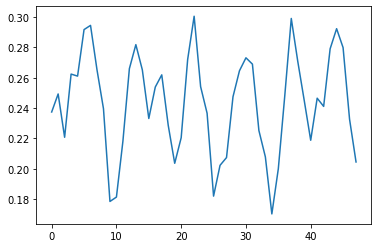

In [26]:
plt.plot(inst_resp_rate)

In [27]:
np.mean(inst_resp_rate) # breaths per second

0.24341063472790467

In [23]:
1 / 3.5275735294117645

0.2834809796769151

In [12]:
interval_lengths

array([251, 405, 439, 434, 440, 331, 345, 247, 149, 386, 379, 274, 310,
       294, 268, 344, 358, 498, 335, 275, 277, 350, 239,  86, 444, 588,
       663, 418, 776, 385, 320, 184, 280, 333, 285, 279, 193, 291, 342,
       309, 182, 271, 310, 247, 333, 401, 390, 382, 587, 390, 418, 325,
       225, 195, 189, 302, 378, 350, 386, 774, 238, 175, 151, 132, 378,
       370, 377, 339, 325, 359, 388, 278, 206, 302, 362, 338, 223, 232,
       413, 458, 350, 205, 281, 328, 241, 261, 500, 403, 359, 457, 438,
       363, 278, 366, 453, 347, 330, 341, 313, 114, 422, 478, 741, 430,
       495, 547, 779, 356, 359, 339, 232, 281, 473, 323, 252, 271, 358,
       358, 384, 450, 551, 367, 293, 414, 386, 285, 220, 216, 272, 349,
       333, 363, 705, 446, 452, 384, 173])

In [17]:
resp_intervals = interval_lengths
is_inhalation = interval_breathe_in
breath_lengths = []
i = 0

while i < len(resp_intervals) - 1:
    if not is_inhalation[i]:
        i = i + 1
    else:
        breath_lengths.append(resp_intervals[i] + resp_intervals[i + 1])
        i = i + 2